In [91]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral
from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg

## Get the current scan frame from the STM, get atom positions using Gaussian fits, and program lateral manipulation moves (in order of their labeling in the figure) using GUI. 
This may require fine-tuning the parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only the surface features you want to see are registered in the image frame when you run the cell.

succeed to connect
	30 centroids


<IPython.core.display.Javascript object>


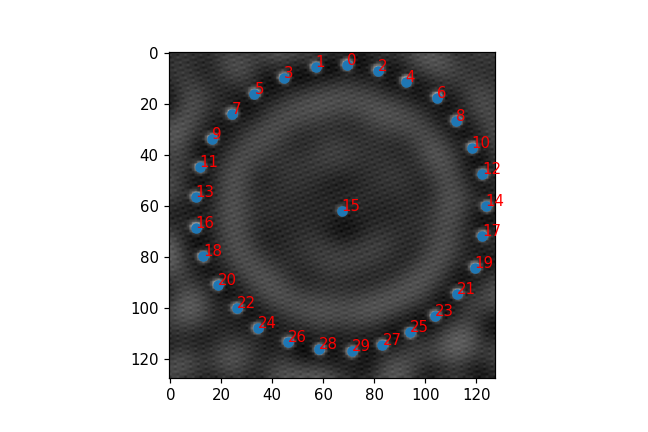

Textarea(value='[]', description='points:')

In [96]:
%matplotlib notebook

CC = Createc_Controller()

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)

# scale numbers between 0 and 1
# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure()
plt.imshow(dispmat)

# show the atom positions
plt.scatter(*np.array(C.centroids).T)

# give numbers to atom positions
for n, c in enumerate(C.centroids):
    plt.text(*c,'%d' %(n), color='r')

# List for selected pixels
selected = []
index = 0

# Create a text area for displaying selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

# Function to run when a pixel is clicked
def onclick(event):
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    global index
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    if (y, x) in selected:
        im[y,x] = C.im[y,x]
        dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
        selected.remove((y, x))
    else:
        dispmat[y,x,:] = [1,0,0]
        selected += [(y, x)]
    text_area.value = str(selected)  # str(dir(event))
    print(selected)
    plt.imshow(dispmat)
    plt.text(x,y,'%d' %(index), color='green')
    index += 1
    fig.canvas.draw()

ka = fig.canvas.mpl_connect('button_press_event', onclick)

### Show atom positions from scan frame and programmed lateral manipulations. 
If they are wrong, run the previous Jupyter notebook cell again and program the lateral manipulations again using the GUI.

	Max height guess different from Gaussian fit on average by: 0.75 Å
	 2022-04-11 13:41:34.626368
	Central atom from Naive fit:  11.063746105813543 [66.70093521 60.93901083]
	Central atom from Gauss fit:  11.05701099888988 [66.57978946 60.80091379]


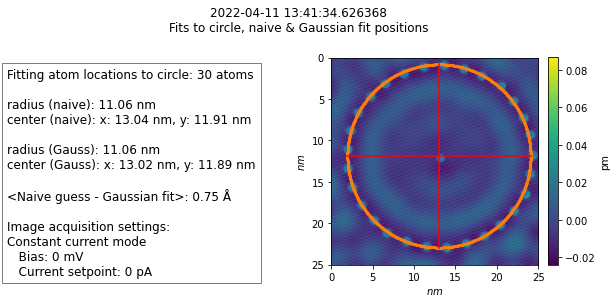

11.05701099888988

In [97]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1.1, savefig=False)

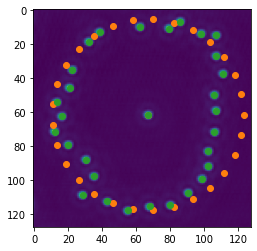

In [87]:
%matplotlib inline

n_wall_atoms = len(C.centroids) - 1
center = C.get_central_atom(C.centroids)

radius = 11
perfect_circle = np.array([[radius*np.cos(t), radius*np.sin(t)] for t in np.arange(0, 2*np.pi, 2*np.pi/(n_wall_atoms))])
perfect_circle = np.concatenate((perfect_circle, [[0,0]]))
perfect_circle = list(map(C.nm_to_pix, perfect_circle))
perfect_circle += np.array(center)

assert(len(perfect_circle)==len(C.centroids))

plt.imshow(C.im);
plt.scatter(*center)
plt.scatter(*(np.array(perfect_circle).T))
plt.scatter(*np.array(C.centroids).T)
plt.show()

In [88]:
import math
refvec = [0, 1]

def clockwiseangle(point, origin):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        print("zero vector")
        return 2*np.pi
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    #if angle < 0:
     #   return 2*math.pi+angle
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle

zero vector


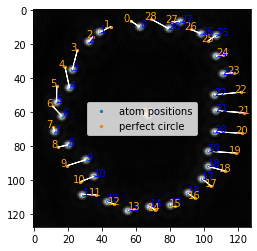

In [89]:
# Kabsch algorithm for the best rotation between two sets to minimize distance
from scipy.spatial.transform import Rotation

# create 3D arrays to align vectors using algorithm
# subtract the center
centroids_3D = np.array(C.centroids) - np.array(center)

# need to order centroids in same order as perfect circle to make Kabsch algo work
clockwise_angle = lambda point: clockwiseangle(point, [0,0])
centroids_3D = np.array(sorted(centroids_3D, key=clockwise_angle))

perfect_circle_3D = np.array(perfect_circle) - np.array(center)

centroids_3D = np.append(centroids_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T
perfect_circle_3D = np.append(perfect_circle_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T

R, rmsd_ = Rotation.align_vectors(centroids_3D, perfect_circle_3D)

applied_rotation = R.apply(perfect_circle_3D)[:,0:2].T
applied_rotation = [x + center for x in applied_rotation.T]

centroids_3D = np.array([c + center for c in centroids_3D[:,0:2]])


plt.imshow(dispmat);

plt.scatter(*np.array(centroids_3D).T, label="atom positions", s=5)
plt.scatter(*np.array(applied_rotation).T, label="perfect circle", s=5)
plt.legend()

for n,c in enumerate(centroids_3D):
    #print(*centroids_3D[:][n], applied_rotation[n])
    initial = pixel_to_nm(centroids_3D[:,][n], dispmat, offset_nm, [len_nm, len_nm])
    
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    
    dx, dy = (np.array(applied_rotation[n]) - np.array(centroids_3D[n]))
    
    plt.text(*c,'%d' %(n), color='blue')
    plt.text(*(applied_rotation[n]-[4,0]),'%d' %(n), color='orange')

    plt.arrow(*centroids_3D[n], dx, dy, color="white")
plt.show()

#np.dot(R.as_matrix(), perfect_circle_3D)

[62.28571429 10.        ] [56.73837876  6.17303377]


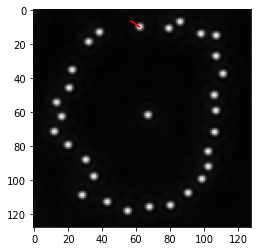

62 10 57 6
[38.5 13. ] [45.08462748  9.67249273]


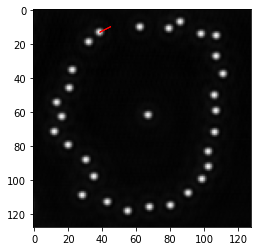

38 13 45 10
[32.         18.71428571] [34.45561466 15.59534833]


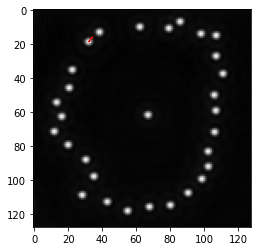

32 19 34 16
[22.5 35. ] [25.34834112 23.66465442]


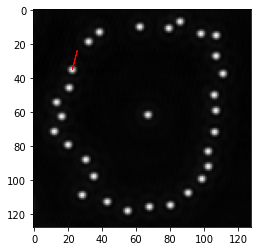

22 35 25 24
[20.83333333 45.83333333] [18.18865287 33.50309922]


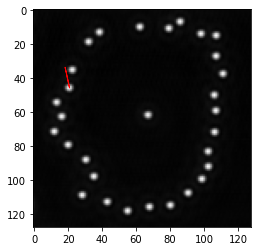

21 46 18 34
[13.16666667 54.16666667] [13.31132895 44.65064798]


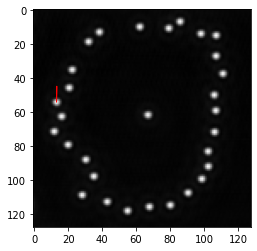

13 54 13 45
[16.5 62.5] [10.94442763 56.58605372]


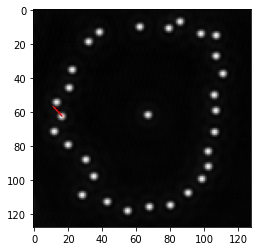

16 62 11 57
[12.  71.5] [11.19862256 68.75123012]


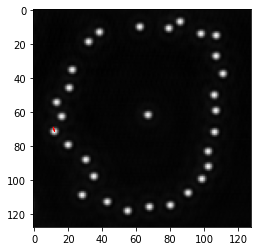

12 72 11 69
[20.         79.28571429] [14.06202789 80.57734706]


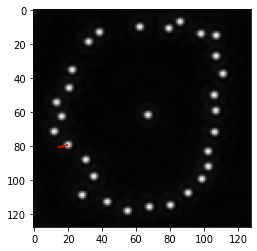

20 79 14 81
[30.5 88. ] [19.40075396 91.51142846]


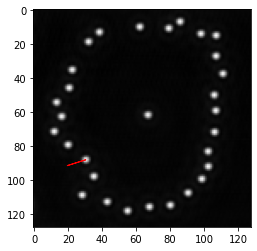

30 88 19 92
[35.16666667 97.83333333] [ 26.96516786 101.04220881]


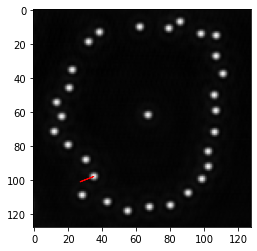

35 98 27 101
[ 28.5 108.5] [ 36.40156603 108.72403944]


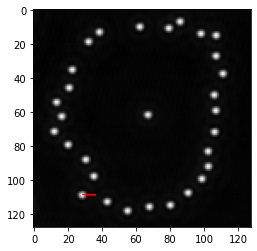

28 108 36 109
[ 43.  112.5] [ 47.26871296 114.19772646]


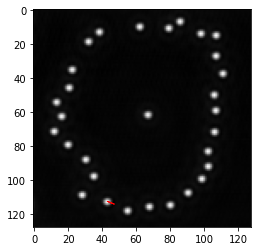

43 112 47 114
[ 55.16666667 117.83333333] [ 59.05847294 117.20732636]


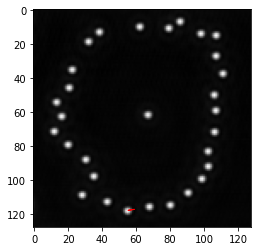

55 118 59 117
[ 68.  115.5] [ 71.2195699  117.61211359]


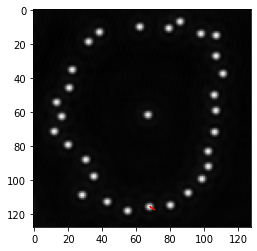

68 116 71 118
[ 80.  114.5] [ 83.18336446 115.39316076]


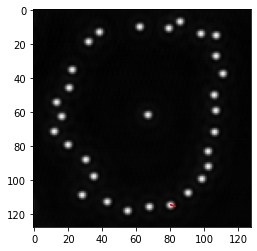

80 114 83 115
[ 90.5 107.5] [ 94.39044288 110.65422363]


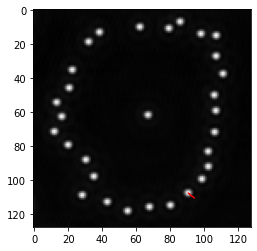

90 108 94 111
[98.83333333 99.16666667] [104.31677464 103.61688963]


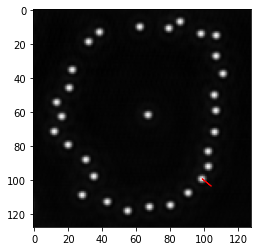

99 99 104 104
[102.5  92. ] [112.49821549  94.61021669]


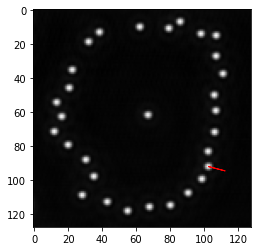

102 92 112 95
[102.28571429  83.        ] [118.55221036  84.05534681]


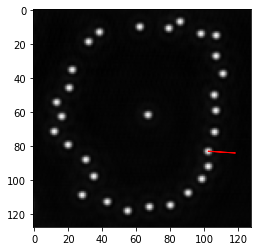

102 83 119 84
[106.   71.5] [122.19568116  72.44581398]


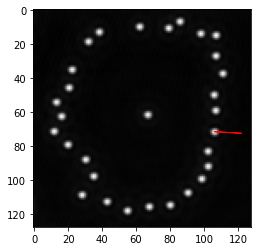

106 72 122 72
[106.83333333  59.16666667] [123.25826325  60.32446706]


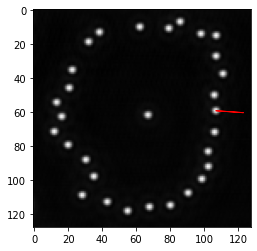

107 59 123 60
[105.83333333  49.83333333] [121.69027149  48.25808674]


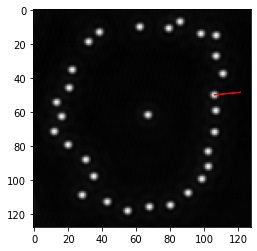

106 50 122 48
[111.   37.5] [117.56502341  36.81088358]


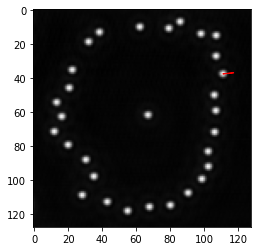

111 38 118 37
[107.  27.] [111.07541104  26.51811606]


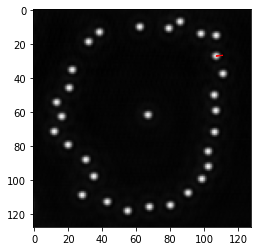

107 27 111 27
[107.16666667  14.83333333] [102.52488143  17.86106255]


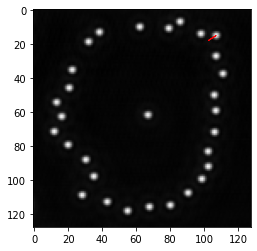

107 15 103 18
[98.16666667 13.83333333] [92.31324785 11.24451726]


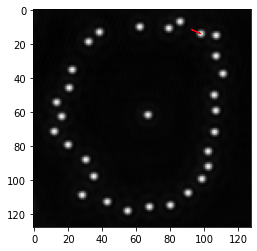

98 14 92 11
[85.83333333  6.83333333] [80.91799494  6.97786249]


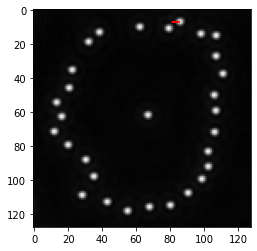

86 7 81 7
[79.16666667 10.83333333] [68.87195205  5.26060226]


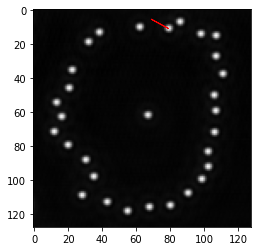

79 11 69 5
[67.  61.5] [67.  61.5]


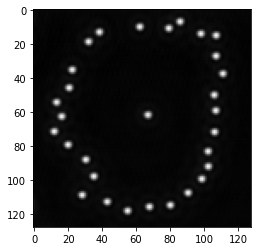

In [90]:
# set the lateral manipulation parameters
latman_millivolt = 2
latman_picoamp = 60000
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# for each "atom" in the image
for n in range(len(centroids_3D)):
    print(centroids_3D[n], applied_rotation[n])
    initial = pixel_to_nm(centroids_3D[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids_3D[n], *(np.array(applied_rotation[n])-np.array(centroids_3D[n])), color='red')
    plt.show()
    
    dist_to_perfect = C.pix_to_nm(np.linalg.norm(np.array(applied_rotation[n])-np.array(centroids_3D[n])))
    if dist_to_perfect > 0.2: # nm 
    # see documentation in AMRL/Environment/createc_control.py
        latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)

array([63.3, 64.3])

## Show the atoms and where you are programming them to go

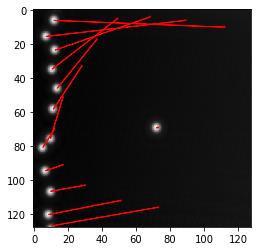

In [50]:
%matplotlib inline
#assert(len(selected)==len(C.centroids))
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
centroids = C.centroids

for n, c in enumerate(C.centroids):
    plt.arrow(*c, *(np.array(list(reversed(selected[n])))-np.array(c)), color="r")
plt.imshow(dispmat);
plt.show()
#

## Program the lateral manipulation parameters and carry out the lateral manipulations in order 

[11.5, 6.0] [112, 10]


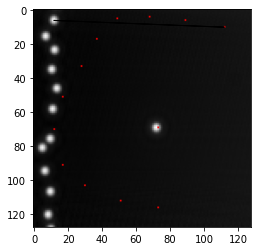

12 6 112 10
[6.846153846153846, 15.461538461538462] [89, 6]


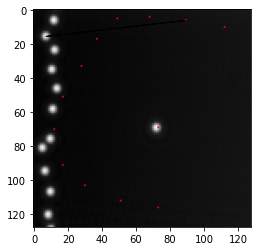

7 15 89 6
[12.285714285714286, 23.5] [68, 4]


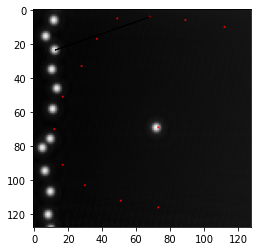

12 24 68 4
[10.5, 34.714285714285715] [49, 5]


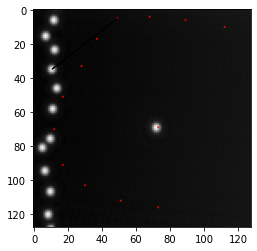

10 35 49 5
[13.5, 46.0] [37, 17]


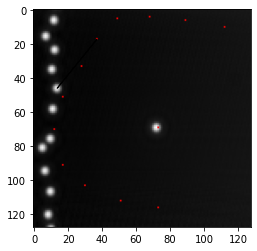

14 46 37 17
[11.25, 58.333333333333336] [28, 33]


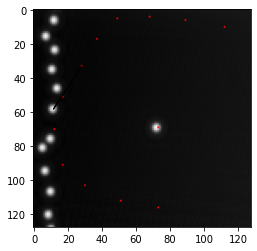

11 58 28 33
[71.875, 69.3125] [73, 69]


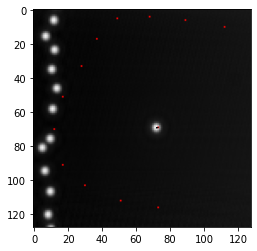

72 69 73 69
[9.615384615384615, 75.61538461538461] [17, 51]


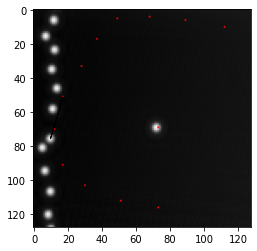

10 76 17 51
[5.071428571428571, 80.85714285714286] [12, 70]


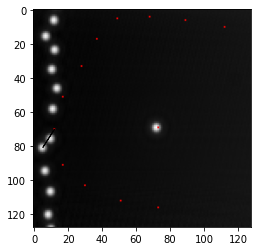

5 81 12 70
[6.5, 94.5] [17, 91]


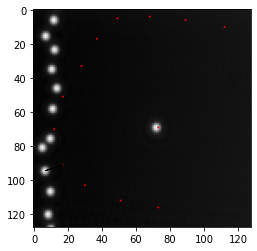

6 94 17 91
[9.615384615384615, 106.61538461538461] [30, 103]


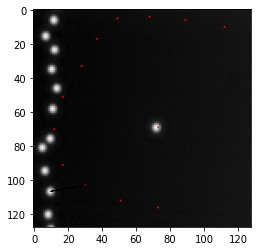

10 107 30 103
[8.5, 120.28571428571429] [51, 112]


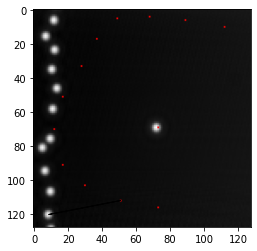

8 120 51 112
[10.0, 127.0] [73, 116]


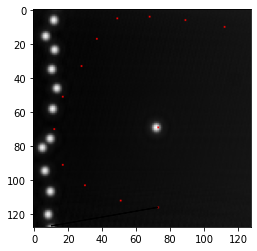

10 127 73 116


In [51]:
# set the lateral manipulation parameters
latman_millivolt = 2
latman_picoamp = 60000

# for each "atom" in the image
for n in range(len(centroids)):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])))
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)

In [250]:
# the units of this is unknown ? 
plt.plot(latmandata.y)

NameError: name 'latmandata' is not defined